# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/training"
VAL_DIR = "/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/validation"
TEST_DIR = "/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing"


MASK_NOISE = "/home/ubuntu/trinh/Edited_Generative_Inpainting/test_dir/GOPR0076/mask/mask.jpg"

BATCH_SIZE = 1

Using TensorFlow backend.


# Creating train & test data generator

In [2]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

    def flow_from_directory_for_test(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            image_mask = cv2.imread(MASK_NOISE)
            image_mask = cv2.resize(image_mask,(512,512))
            image_mask[image_mask <=128] = 128
            image_mask[image_mask > 128] = 0
            image_mask[image_mask > 0] = 255
            
            
            mask = np.stack([image_mask for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori            
            
# Create training generator
train_datagen = DataGenerator(  
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip =True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(512, 512), batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory_for_test(
    TEST_DIR, target_size=(512, 512), batch_size=BATCH_SIZE, seed=1
)

Found 1888 images belonging to 3 classes.


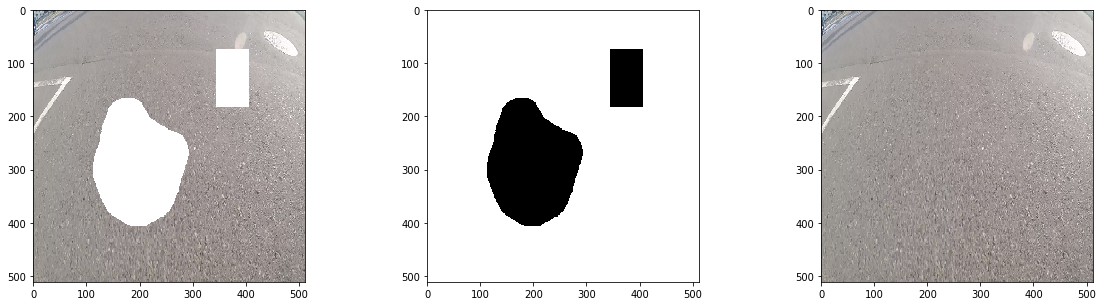

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:])
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

RUN FROM HERE

## Phase 3 - Generating samples

In [4]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(512, 512))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]


    # convert black <-> white
    image_mask = cv2.imread(MASK_NOISE)
    image_mask = cv2.resize(image_mask,(512,512))
    image_mask[image_mask <=128] = 128
    image_mask[image_mask > 128] = 0
    image_mask[image_mask > 0] = 255
  
    
    # load conresponding mask
    mask = np.stack([image_mask for _ in range(ori.shape[0])], axis=0)

    # random mask
#     mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
        
    # Apply masks to all image sample
    masked = deepcopy(img_tensor)
    masked[mask==0] = 1
    
    if show:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(mask[i,:,:,:])
        axes[2].imshow(img_tensor[i,:,:,:])
        plt.show()
        
#         plt.imshow(mask[0])
#         plt.axis('off')
#         plt.show()
        
#         plt.imshow(masked[0])                           
#         plt.show()
        
#         plt.imshow(img_tensor[0])                           
#         plt.show()
        

    
    return [masked, mask]


In [5]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load("/home/ubuntu/trinh/Edited_PConv-Keras/data/logs/139_weights_2018-08-25-21-20-24.h5")

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop0013.jpg
(1, 512, 512, 3)
--- Executed time: 0.14124774932861328 seconds ---


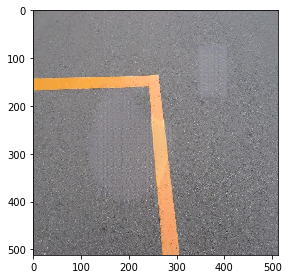

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop0219.jpg
(1, 512, 512, 3)
--- Executed time: 0.1373765468597412 seconds ---


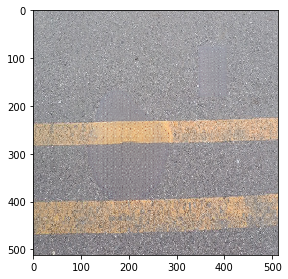

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop0415.jpg
(1, 512, 512, 3)
--- Executed time: 0.11481380462646484 seconds ---


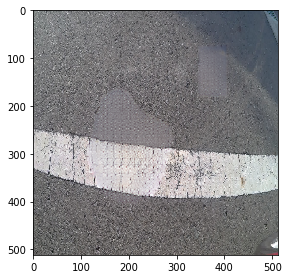

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop10973.jpg
(1, 512, 512, 3)
--- Executed time: 0.11208510398864746 seconds ---


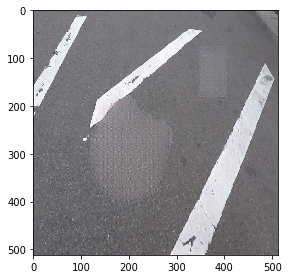

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop11148.jpg
(1, 512, 512, 3)
--- Executed time: 0.1222677230834961 seconds ---


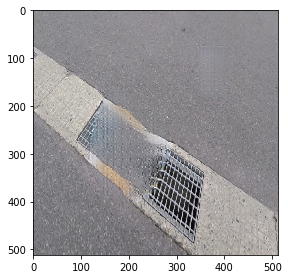

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop12148.jpg
(1, 512, 512, 3)
--- Executed time: 0.11134696006774902 seconds ---


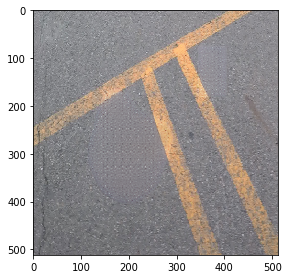

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop16019.jpg
(1, 512, 512, 3)
--- Executed time: 0.12628531455993652 seconds ---


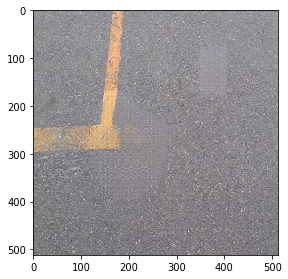

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop1978.jpg
(1, 512, 512, 3)
--- Executed time: 0.11031699180603027 seconds ---


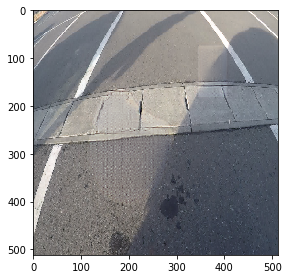

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop2117.jpg
(1, 512, 512, 3)
--- Executed time: 0.12173104286193848 seconds ---


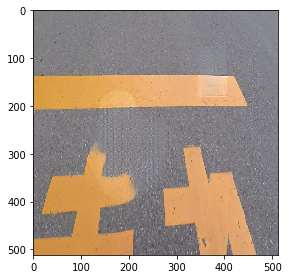

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop2246.jpg
(1, 512, 512, 3)
--- Executed time: 0.10608220100402832 seconds ---


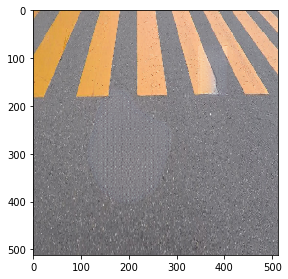

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop2292.jpg
(1, 512, 512, 3)
--- Executed time: 0.11024355888366699 seconds ---


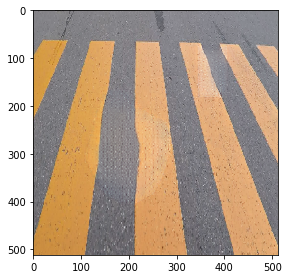

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop3188.jpg
(1, 512, 512, 3)
--- Executed time: 0.10726690292358398 seconds ---


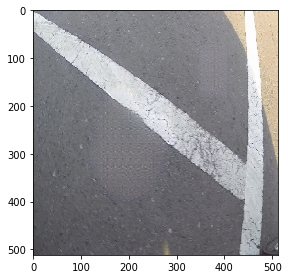

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop3448.jpg
(1, 512, 512, 3)
--- Executed time: 0.10800385475158691 seconds ---


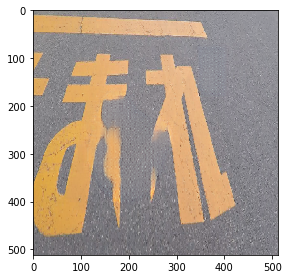

/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection/raindrop8755.jpg
(1, 512, 512, 3)
--- Executed time: 0.11261296272277832 seconds ---


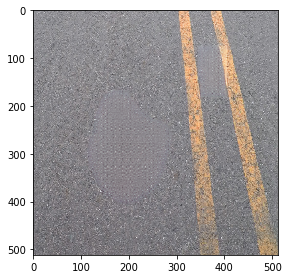

In [28]:
from PIL import Image as PImage
import os
import time

# TEST_DIR_RUN = "/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/GOPR0037_taken"
TEST_DIR_RUN = "/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/collection"

dir_files = os.listdir(TEST_DIR_RUN)
dir_files.sort()
count = 0

for image_item in dir_files:
    # count time
    start_time = time.time()
    
    base_file_name = os.path.basename(image_item) 
    print(TEST_DIR_RUN +"/" + base_file_name)
    img_path = TEST_DIR_RUN +"/" + base_file_name    # dog
    # load a single image
    new_image = load_image(img_path, False)

    # check prediction
    pred = model.predict(new_image)
    print(pred.shape)
    print("--- Executed time: %s seconds ---" % (time.time() - start_time))
    
    # write images
    im = image.array_to_img(pred[0,:,:,:] * 1.)
    im.save("/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/output/" + base_file_name)
    
    
    plt.figure(figsize=(4.5,4.5))
    plt.imshow(im, interpolation='nearest')
    # plt.savefig("/home/ubuntu/trinh/Edited_Generative_Inpainting/training_data/testing/output/" + base_file_name)
    plt.show()
    count +=1
#     if count> 5:
#         break
    

### old method to run

In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    print(pred_img.shape)
    plt.imshow(pred_img[0,:,:,:] * 1., interpolation='nearest')
    plt.show()
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
#         plt.savefig(r'data/results/img_{}_{}.png'.format(i, pred_time))
        plt.savefig(r'data/results/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 2:
        break